# Riverswim implementation

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

class Riverswim:
    def __init__(self, states_count, actions_count=2, gamma=0.95):
        self.states_count = states_count
        self.actions_count = actions_count
        self.P = np.zeros((states_count, actions_count, states_count))
        self.R = np.zeros((states_count, actions_count))
        self.Q = np.zeros((states_count, actions_count))
        self.gamma = gamma  # Discount factor
        self.terminal_state = states_count - 1  # Define the rightmost state as terminal

        for s in range(states_count):
            if s == 0:
                self.P[s, 0, s] = 1
                self.P[s, 1, s] = 0.6
                self.P[s, 1, s + 1] = 0.4
                self.R[s, 0] = 0.05
            elif s == states_count - 1:
                self.P[s, 0, s - 1] = 1
                self.P[s, 1, s] = 0.6
                self.P[s, 1, s - 1] = 0.4
                self.R[s, 1] = 1 
            else:
                self.P[s, 0, s - 1] = 1
                self.P[s, 1, s] = 0.55
                self.P[s, 1, s + 1] = 0.4
                self.P[s, 1, s - 1] = 0.05
                
        self.s = 0  # Start state
        self.max_state = 0

    def reset(self):
        self.s = 0
        return self.s

    def step(self, epsilon=0.2):
        """ Take an epsilon-greedy step """
        if np.random.rand() < epsilon:
            action = np.random.randint(self.actions_count)
        else:
            action = np.argmax(self.Q[self.s])

        # Transition probability for the chosen action
        p = self.P[self.s, action]
        next_state = np.random.choice(self.states_count, p=p)
        reward = self.R[self.s, action]
        
        # Update the current state
        self.s = next_state
        if self.max_state < next_state:
            # print("Yay changing max state from", self.max_state, "to", next_state)
            self.max_state = next_state
        
        return next_state, reward, action
    
    def q_star_via_qvi(self):
        # Threshold for convergence
        threshold = 1e-10
        Q_star = np.zeros((self.states_count, self.actions_count))
        while True:
            delta = 0
            Q_temp = Q_star.copy()
            for s in range(self.states_count):
                for a in range(self.actions_count):
                    Q_star[s, a] = self.R[s, a] + self.gamma * sum(self.P[s, a, s_prime] * max(Q_temp[s_prime]) for s_prime in range(self.states_count))
                    delta = max(delta, abs(Q_star[s, a] - Q_temp[s, a]))
                    
            if delta < threshold:
                break
            
        return Q_star
    
    def mb_opo(self, alpha_func, epsilon=0.2, horizon=10e6, q_per=1):
        Q_error_history = []
        Q_loss_history = []
        Q_star = self.q_star_via_qvi()
        
        # Initializing variables
        N_s = np.zeros(self.states_count)
        N_sa = np.ones((self.states_count, self.actions_count))
        N_ss_a = np.zeros((self.states_count, self.actions_count, self.states_count))
        rewards = np.zeros((self.states_count, self.actions_count))

        # Initialize estimated model matrices
        P_hat = np.zeros((self.states_count, self.actions_count, self.states_count))
        R_hat = np.zeros((self.states_count, self.actions_count))
        
        # self.Q = np.zeros((self.states_count, self.actions_count))  # Reset Q
        # Randomize inital Q between 0 and 1
        self.Q = np.random.rand(self.states_count, self.actions_count)
        for t in tqdm(range(int(horizon)), desc='Model-based OPO Progress'):
            # Store current state
            state = self.s
            
            # Take a step using the epsilon-greedy policy
            next_state, reward, action = self.step(epsilon)
            
            # Update counters
            N_s[state] += 1
            N_sa[state, action] += 1
            N_ss_a[state, action, next_state] += 1
            rewards[state, action] += reward
            
            if t % q_per != 0:
                continue
            
            alpha = alpha_func(N_sa[state, action])
            # Update estimated model with current data
            for s_prime in range(self.states_count):
                P_hat[state, action, s_prime] = (N_ss_a[state, action, s_prime] + alpha) / (N_sa[state, action] + alpha * self.states_count)
                
            R_hat[state, action] = (rewards[state, action] + alpha) / (N_sa[state, action] + alpha)
            
            # Perform Q-value iteration using the estimated model
            for s in range(self.states_count):
                for a in range(self.actions_count):
                    self.Q[s, a] = R_hat[s, a] + self.gamma * np.sum(
                        [P_hat[s, a, s_prime] * np.max(self.Q[s_prime]) for s_prime in range(self.states_count)]
                    )

            # Store the max error in Q-values and return loss in history for plotting
            Q_error_history.append(np.max(np.abs(Q_star - self.Q)))
            Q_loss_history.append(Q_star[0, 1] - self.Q[0, 1])

        # Calculate the final policy from Q-values
        optimal_policy = np.argmax(self.Q, axis=1)

        # Return error and loss histories along with the optimal policy
        return Q_error_history, Q_loss_history, optimal_policy, self.Q

    def q_learning(self, alpha_func, epsilon=0.2, horizon=10e6):
        Q_error_history = []
        Q_loss_history = []
        Q_star = self.q_star_via_qvi()
        N_sa = np.ones((self.states_count, self.actions_count))
        
        # Initialization of Q values, which could be random or all zeros
        self.Q = np.random.rand(self.states_count, self.actions_count)

        for t in tqdm(range(int(horizon)), desc='Q-learning Progress'):
            # Store current state
            state = self.s
            
            next_state, reward, action = self.step(epsilon)
            
            N_sa[state, action] += 1
            
            # Update rule for Q-learning
            alpha = alpha_func(N_sa[state, action])
            
            target_t = reward + self.gamma * self.Q[next_state, np.argmax(self.Q[next_state])]
            delta_t = target_t - self.Q[state, action]
            
            # Update Q-values (s_t and a_t only)
            self.Q[state, action] += alpha * delta_t
            
            # Update error and loss histories
            Q_error_history.append(np.max(np.abs(Q_star - self.Q)))
            Q_loss_history.append(Q_star[0, 1] - self.Q[0, 1])

            # Update the state
            self.s = next_state

        # Calculate the final policy from Q-values
        optimal_policy = np.argmax(self.Q, axis=1)

        # Return Q-value history, error history, loss history, and the optimal policy
        return self.Q, Q_error_history, Q_loss_history, optimal_policy
    
    def double_q_learning(self, alpha_func, epsilon=0.2, horizon=10e6):
        Q_error_history = []
        Q_loss_history = []
        Q_star = self.q_star_via_qvi()
        N_sa = np.ones((self.states_count, self.actions_count))
        
        # Initialization of Q values, which could be random or all zeros
        Q_A = np.random.rand(self.states_count, self.actions_count)
        Q_B = np.random.rand(self.states_count, self.actions_count)

        for t in tqdm(range(int(horizon)), desc='Double Q-learning Progress'):
            # Store current state
            state = self.s
            
            next_state, reward, action = self.step(epsilon)
            
            N_sa[state, action] += 1
            
            # Update rule for Double Q-learning
            alpha = alpha_func(N_sa[state, action])
            if np.random.rand() < 0.5:
                # Update Q_A
                best_next_action = np.argmax(Q_A[next_state])
                delta_t = reward + self.gamma * Q_B[next_state, best_next_action] - Q_A[state, action]
                Q_A[state, action] += alpha * delta_t
            else:
                # Update Q_B
                best_next_action = np.argmax(Q_B[next_state])
                delta_t = reward + self.gamma * Q_A[next_state, best_next_action] - Q_B[state, action]
                Q_B[state, action] += alpha * delta_t
            
            # Update error and loss histories
            combined_Q = (Q_A + Q_B) / 2
            
            Q_error_history.append(np.max(np.abs(Q_star - combined_Q)))
            Q_loss_history.append(Q_star[0, 1] - combined_Q[0, 1])

            # Update the state
            self.s = next_state

        # Calculate the final policy from combined Q-values
        optimal_policy = np.argmax(combined_Q, axis=1)

        # Return Q-value history, error history, loss history, and the optimal policy
        return combined_Q, Q_error_history, Q_loss_history, optimal_policy


# Plots

In [19]:
import seaborn as sns


def plot_combined_history(Q_loss_history, Q_error_history, epsilon, downsample_rate=10000, title=None, filename="plot.png"):
    # Downsampling for efficient plotting
    times = list(range(0, len(Q_loss_history), downsample_rate))
    downsampled_loss = Q_loss_history[::downsample_rate]
    downsampled_error = Q_error_history[::downsample_rate]
    
    # Plotting
    plt.figure(figsize=(15, 7))
    # Make all plot text a larger font size
    plt.rcParams.update({'font.size': 34})
    
    sns.lineplot(x=times, y=downsampled_loss, label='Q Loss', linewidth=2.5)
    sns.lineplot(x=times, y=downsampled_error, label='Q Error', linewidth=2.5)

    plt.title(title or 'Q Loss and Q Error Over Time (Downsampled)')
    plt.xlabel('Time (iterations)')
    plt.ylabel(f'Value (eps={epsilon})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"artifacts/6_opo_eps_{epsilon}_"+filename)
    plt.show()

# Parameters

In [5]:
epsilon = 0.2
states_count = 5
horizon = 10e6
q_per=100

# MB OPO

In [6]:
env = Riverswim(states_count)
mb_Q_error_history, mb_Q_loss_history, mb_optimal_policy, mb_Q = env.mb_opo(alpha_func=lambda x: 0, epsilon=0.4, horizon=10e6, q_per=q_per)

Model-based OPO Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

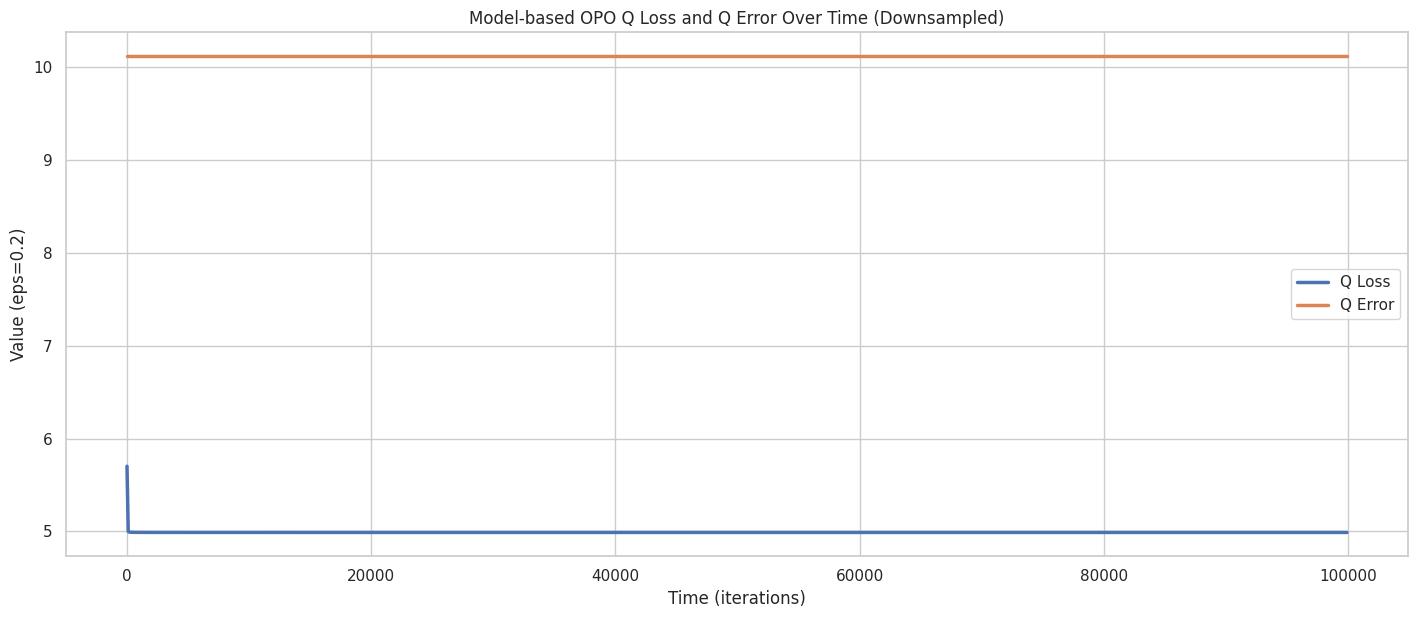

[0 0 0 0 0]


In [20]:
plot_combined_history(mb_Q_loss_history, 
                      mb_Q_error_history, 
                      epsilon,
                      downsample_rate=100, 
                      title='Model-based OPO Q Loss and Q Error Over Time (Downsampled)',
                      filename='mb_opo_loss_error.png')
print(mb_optimal_policy)

# Q-learning

In [8]:
env = Riverswim(states_count)
alpha = lambda n_sa: 2/(n_sa**(2/3)+1)
Q, Q_error_history, Q_loss_history, Q_optimal_policy = env.q_learning(alpha_func=alpha, epsilon=epsilon, horizon=horizon)

Q-learning Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

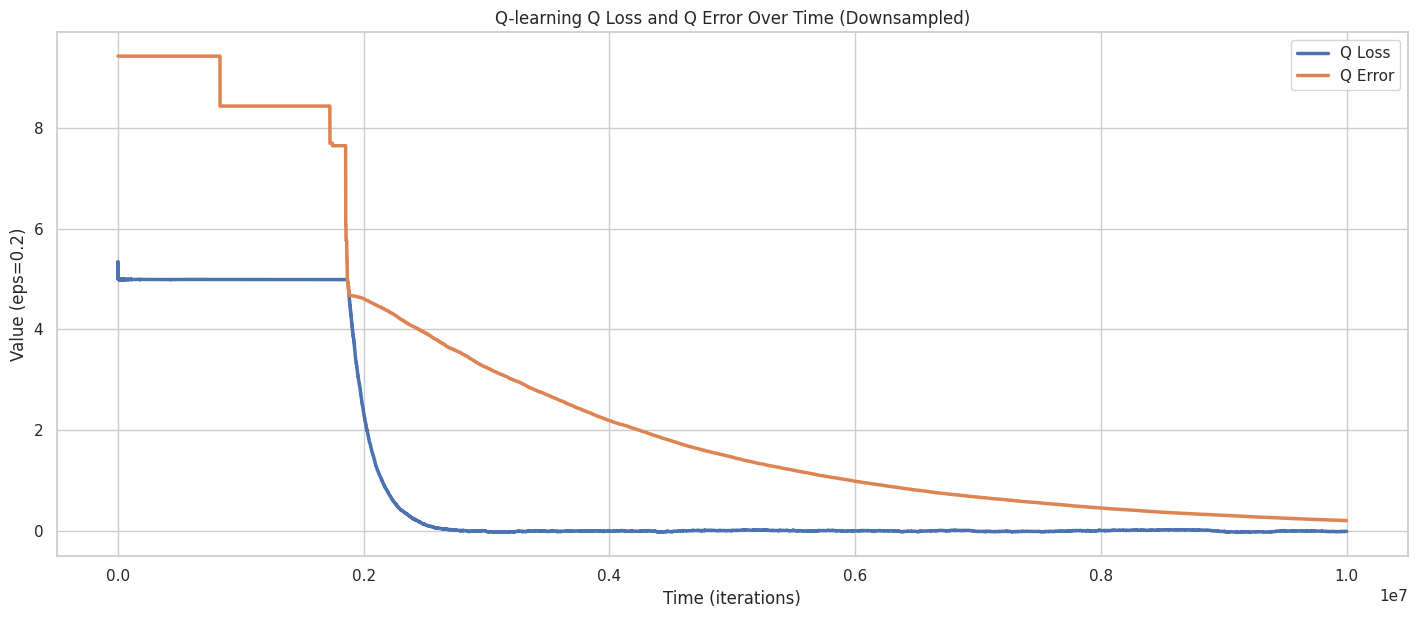

[1 1 1 1 1]


In [21]:
plot_combined_history(Q_loss_history, 
                      Q_error_history, 
                      epsilon,
                      downsample_rate=10, 
                      title='Q-learning Q Loss and Q Error Over Time (Downsampled)',
                      filename='q_learning_loss_error.png')
print(Q_optimal_policy)

# Double Q-learning

In [10]:
env = Riverswim(states_count)
alpha = lambda n_sa: 2/(n_sa**(2/3)+1)
DQ, DQ_error_history, DQ_loss_history, DQ_optimal_policy = env.double_q_learning(alpha_func=alpha, epsilon=epsilon, horizon=horizon)

Double Q-learning Progress:   0%|          | 0/10000000 [00:00<?, ?it/s]

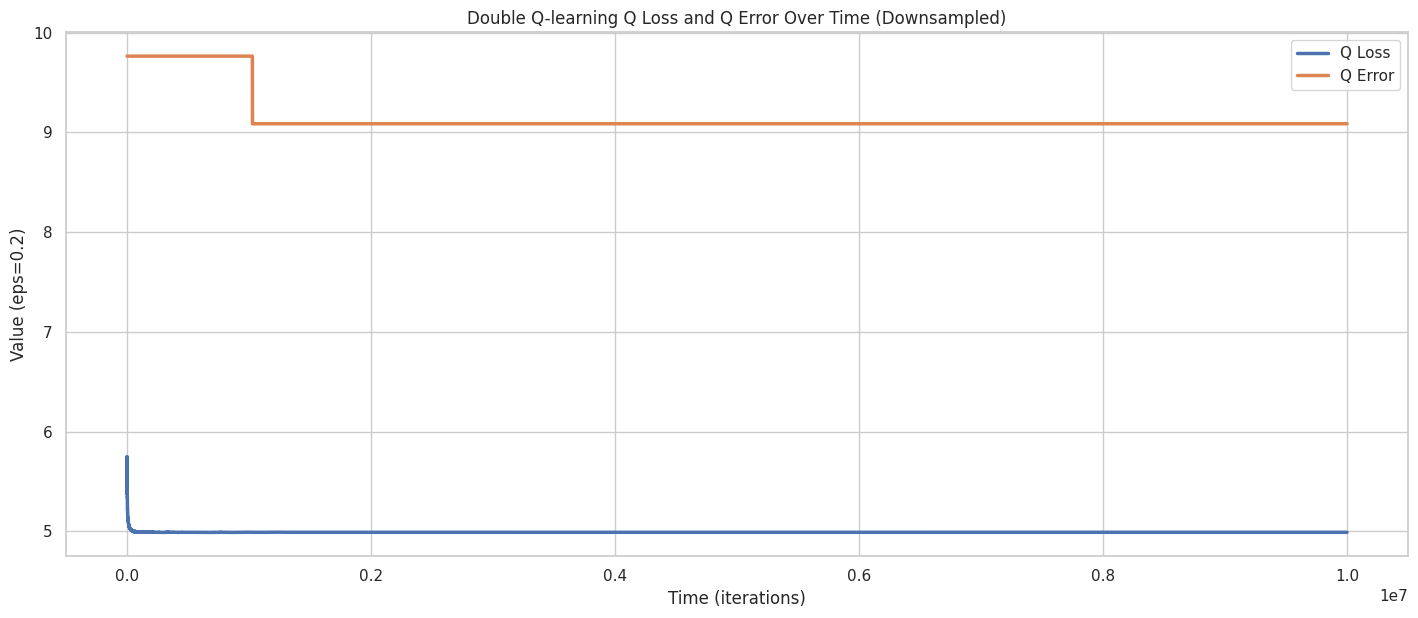

[0 0 0 0 1]


In [22]:
plot_combined_history(DQ_loss_history, 
                      DQ_error_history, 
                      epsilon,
                      downsample_rate=10, 
                      title='Double Q-learning Q Loss and Q Error Over Time (Downsampled)',
                      filename='dq_learning_loss_error.png')
print(DQ_optimal_policy)

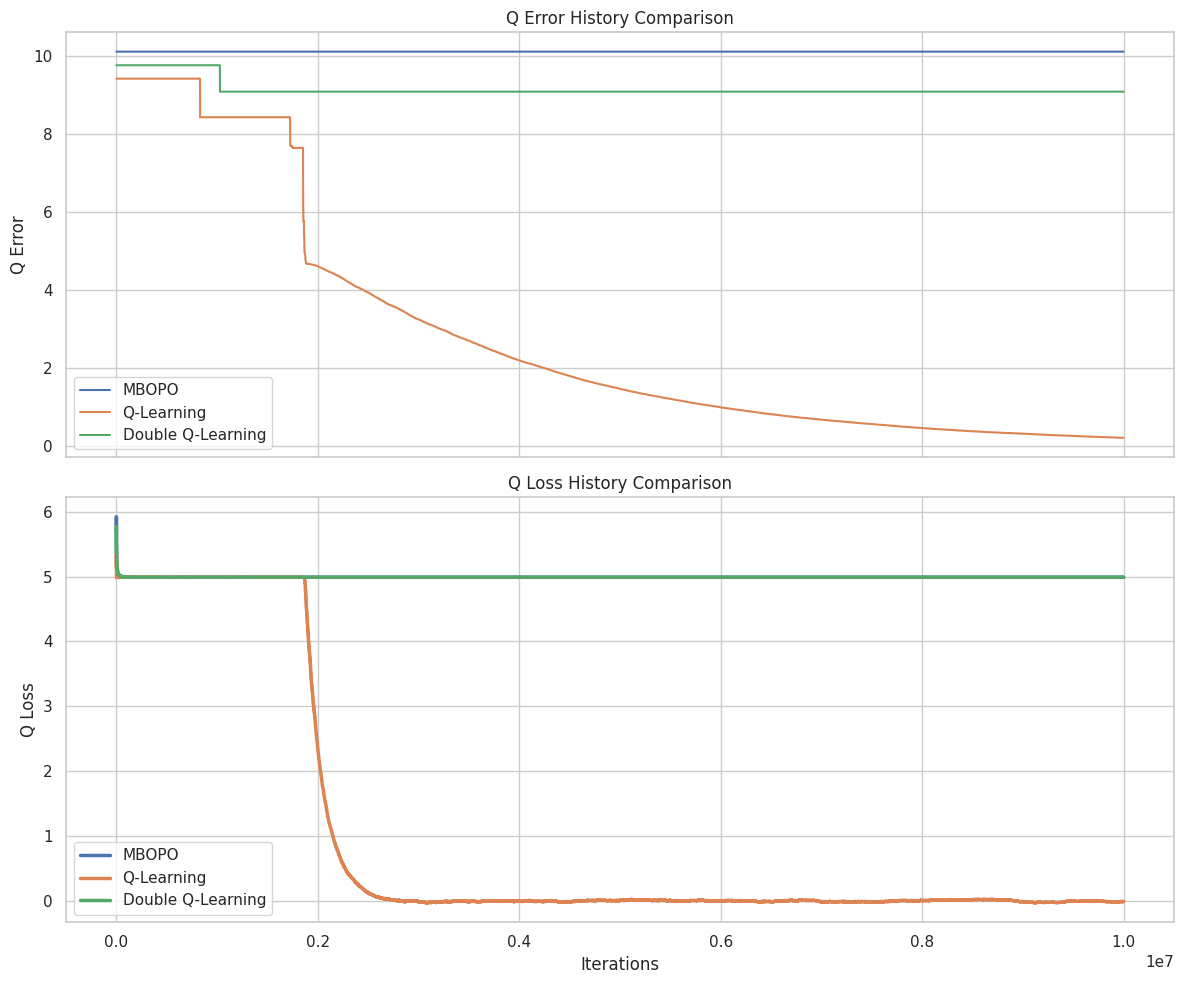

In [12]:
sns.set(style="whitegrid")

def plot_stacked_histories(error_histories, loss_histories, labels):
    # Extend mb error and loss ([0]) with q_per pr entry such that each value gets duplicated q_per times
    error_histories[0] = [val for val in error_histories[0] for _ in range(q_per)]
    loss_histories[0] = [val for val in loss_histories[0] for _ in range(q_per)]
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), sharex=True)

    # Plot all error histories in the top subplot
    for error_history, label in zip(error_histories, labels):
        sns.lineplot(ax=axes[0], data=error_history, label=label)
    axes[0].set_title('Q Error History Comparison')
    axes[0].set_ylabel('Q Error')
    axes[0].legend()

    # Plot all loss histories in the bottom subplot
    for loss_history, label in zip(loss_histories, labels):
        sns.lineplot(ax=axes[1], data=loss_history, label=label, linewidth=2.5)
    axes[1].set_title('Q Loss History Comparison')
    axes[1].set_xlabel('Iterations')
    axes[1].set_ylabel('Q Loss')
    axes[1].legend()

    plt.tight_layout()
    plt.savefig(f"artifacts/6_opo_stacked_eps_{epsilon}.png")
    plt.show()
    

# Example usage
# Assuming the histories are lists containing your data and labels is a list of names of the algorithms
plot_stacked_histories(
    [mb_Q_error_history, Q_error_history, DQ_error_history],
    [mb_Q_loss_history, Q_loss_history, DQ_loss_history],
    ['MBOPO', 'Q-Learning', 'Double Q-Learning']
)